In [6]:
!pip install -r requirements.txt

In [ ]:
'''
Overall whats happening
```````````````````````
Playing different machines 500 times and looking at the reward each time and storing it in the memory array 
in the format of [index of machine played, reward obtained in the play].

How do we get eache of the above?
`````````````````````````````````
Index of the machine played: This can be selected in two ways

1. Random (Exploration): Look at the else statement of the final code block
2. Based on prior exp (Exploitation): The bestArm function spits out the arm that gave the best reward when fed with the 
    memory array. 

Which of these strategies are taken is decided based on epsilon which is the probability of exploration action

'''

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(5)

In [8]:
n = 10
arms = np.random.rand(n)
eps = 0.1 #probability of exploration action

In [9]:
def reward(prob):
    reward = 0
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

In [128]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

In [126]:
#greedy method to select best arm based on memory array
def bestArm(a):
    bestArm = 0 #default to 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:,0] == u[0])][:, 1]) #calculate mean reward for each action
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

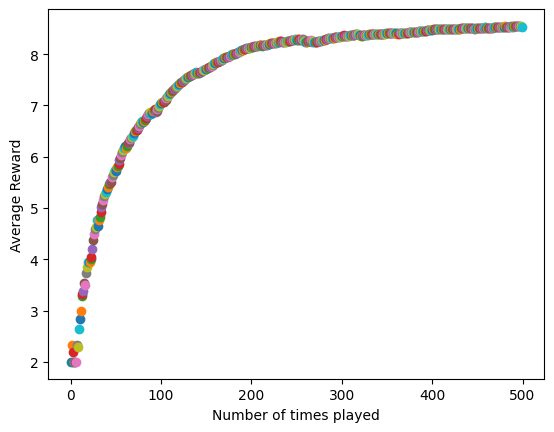

In [130]:
plt.xlabel("Number of times played")
plt.ylabel("Average Reward")
for i in range(500):
    if random.random() > eps: #greedy exploitation action
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #exploration action
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)